In [81]:
from keras.preprocessing.image import ImageDataGenerator

In [82]:
datagen = ImageDataGenerator(rescale=1./255)
datadir = './datasets/celebs'

In [3]:
train_generator = datagen.flow_from_directory(
    datadir,
    target_size = (128,128),
    batch_size = 5000,
)

Found 202599 images belonging to 1 classes.


In [4]:
valid_generator = datagen.flow_from_directory(
    datadir,
    target_size = (128,128),
    batch_size = 1000,
)

Found 202599 images belonging to 1 classes.


In [5]:
train_x = next(train_generator)[0]

In [6]:
valid_x = next(valid_generator)[0]
valid_x.shape

(1000, 128, 128, 3)

In [83]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np


In [133]:
img_shape = (128,128,3)
batch_size = 32
latent_dim = 64

In [134]:
input_img = keras.Input(shape = img_shape)
x = layers.Conv2D(32,3,padding='same',activation='relu')(input_img)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128,3,padding='same',activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(256,activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)  # The input encoded in these two vectors

In [135]:
model = Model(input_img,z_mean)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 128)       0  

In [136]:
# Latent space sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [137]:
K.int_shape(z)

(None, 64)

In [138]:
# VAE Decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(128,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2DTranspose(64,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2DTranspose(32,3,padding='same',activation='relu',strides=(2,2))(x)
x = layers.Conv2DTranspose(3,3,padding='same',activation='relu',strides=(2,2))(x)

In [139]:
encoder = Model(input_img,[z_mean,z_log_var])
decoder = Model(decoder_input,x)
z_decoded = decoder(z)

In [140]:
decoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8192)              532480    
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 128, 128, 3)       867

In [141]:
# CAlculating loss using a keras layer
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self,x,z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss+kl_loss)
    def call(self,inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x,z_decoded)
        self.add_loss(loss,inputs=inputs)
        return x

In [142]:
y = CustomVariationalLayer()([input_img,z_decoded])

In [143]:
vae = Model(input_img,y)
vae.compile(optimizer='rmsprop',loss=None)
vae.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 64)   18496       max_pooling2d_13[0][0]           
___________________________________________________________________________________________

/home/shrey/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_4 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_4.
  'be expecting any data to be passed to {0}.'.format(name))


In [157]:
history = vae.fit(x=train_x,y=None,shuffle=True,epochs=10,batch_size=batch_size,validation_data=(valid_x,None))

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 131s 26ms/step - loss: 0.5417 - val_loss: 0.5510
Epoch 2/10
5000/5000 [==============================] - 120s 24ms/step - loss: 0.5391 - val_loss: 0.5420
Epoch 3/10
5000/5000 [==============================] - 127s 25ms/step - loss: 0.5370 - val_loss: 0.5374
Epoch 4/10
2400/5000 [=============>................] - ETA: 1:02 - loss: 0.5375

KeyboardInterrupt: 

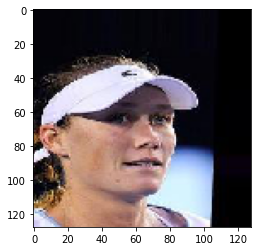

In [156]:
import matplotlib.pyplot as plt
test = train_x[70]
plt.imshow(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


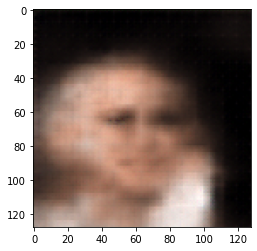

In [155]:
test = train_x[70]
test = np.expand_dims(test,axis=0)
mean,log_var = encoder.predict(test,batch_size=1)
test_decoded = decoder.predict(mean,batch_size=1)
test_decoded.shape
test_decoded = test_decoded.reshape(128,128,3)
plt.imshow(test_decoded)

In [125]:
mean.std()

1.1934952

In [126]:
# Then we can use the decoder network to turn latent space to images
import matplotlib.pyplot as plt
from scipy.stats import norm

n=15
digit_size = 128
figure = np.zeros((digit_size*n,digit_size*n,3))
grid_x = np.linspace(-1,3,n)
grid_y = np.linspace(-1,3,n)


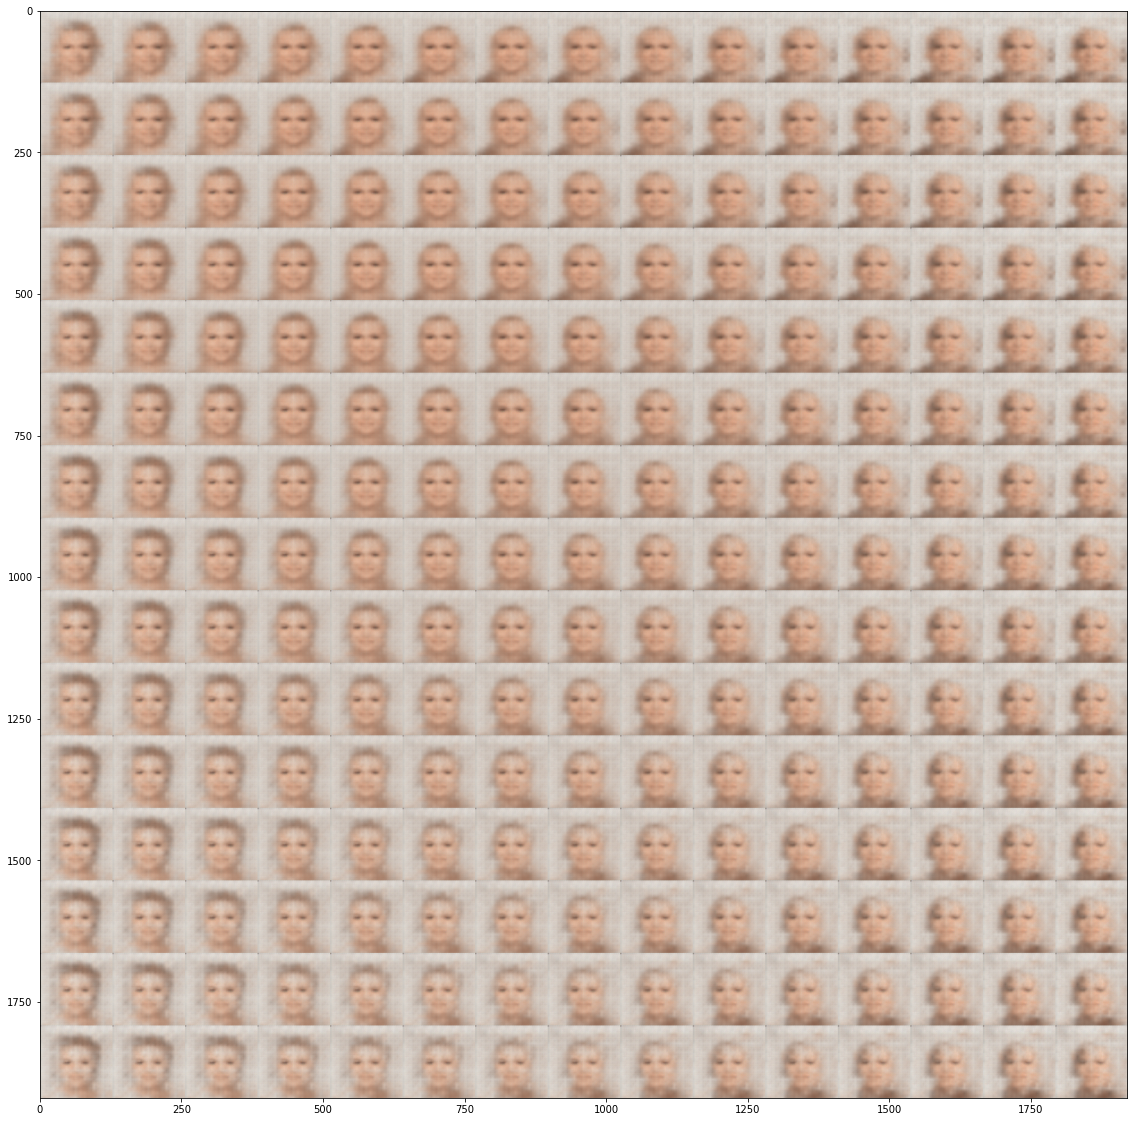

In [127]:
for i,yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample = np.array([xi,0,0,yi])
        for k in range(latent_dim-4):
            z_sample = np.append(z_sample,0)
        z_sample = np.expand_dims(z_sample,axis=0)
        #print(z_sample.shape)
        #z_sample = np.array([[xi,0,yi,0,0,0,0,0]])
        #z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 4)
        x_decoded = decoder.predict(z_sample,batch_size=1)
        digit = x_decoded.reshape(digit_size,digit_size,3)
        #print(digit.shape)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size,:] = digit

plt.figure(figsize=(20,20))
plt.imshow(figure)
plt.show()